# Bias Mitigation
## Overview 

We have demonstrated in other recipes recipes how to develop an effective Trainee from a results perspective. We were able to find possible outlier cases and edit our Trainee. However, there may be a situation where data in our Trainee is technically correct but there are harmful or unnessary underlying trends and biases in that data. Howso Engine enables biases in data to be identified, understood, and mitigated.


## Recipe Goals:

This recipe will show how Howso Engine can provide organizations opportunities to identify data biases for a variety of use cases, empowering true, ethical data insights.

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.io as pio
from pmlb import fetch_data
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes
from howso.visuals import compose_figures

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

# Section 1: Train and Analyze


For questions about the specific steps of this section, please see the [basic workflow guide](https://docs.howso.com/user_guide/basics/basic_workflow.html).

### Step 1: Load Data

Our example dataset for this recipe continues to be the well known `Adult` dataset. This dataset consists of 14 Context Features and 1 Action Feature. The Action Feature in this version of the `Adult` dataset has been renamed to `target` and it takes the form of a binary indicator for whether a person in the data makes over $50,000/year (*target*=1) or less (*target*=0).

In [2]:
# We use the full dataset in this Recipe
df = fetch_data('adult', local_cache_dir="../../data/adult")

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39.0,7,77516.0,9,13.0,4,1,1,4,1,2174.0,0.0,40.0,39,1
1,50.0,6,83311.0,9,13.0,2,4,0,4,1,0.0,0.0,13.0,39,1
2,38.0,4,215646.0,11,9.0,0,6,1,4,1,0.0,0.0,40.0,39,1
3,53.0,4,234721.0,1,7.0,2,6,0,2,1,0.0,0.0,40.0,39,1
4,28.0,4,338409.0,9,13.0,2,10,5,2,0,0.0,0.0,40.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39.0,4,215419.0,9,13.0,0,10,1,4,0,0.0,0.0,36.0,39,1
48838,64.0,0,321403.0,11,9.0,6,0,2,2,1,0.0,0.0,40.0,39,1
48839,38.0,4,374983.0,9,13.0,2,10,0,4,1,0.0,0.0,50.0,39,1
48840,44.0,4,83891.0,9,13.0,0,1,3,1,1,5455.0,0.0,40.0,39,1


### Step 2: Train Trainee

To highlight the possible bias, we filter our test dataset to control for features that likely have a major impact on the target, such as `workclass` and `education`. This is not necessarily something that is known beforehand, however through the use of techiniques like determining feature relevance, we can deduce which variables might be candidates to be controlled. This is only for demonstrative purposes and these features may not represent a complete set of confounding variables.

In [3]:
features = infer_feature_attributes(df)

# We use a train-test split so we can reduce bias in the test set
X_train, X_test = train_test_split(df, test_size=0.2)

t = Trainee(features=features, overwrite_existing=True)

t.train(X_train)

t.analyze()

# Now that the model is trained and analyzed, We try to control for confounding factors for this experiment.
X_test = X_test[(X_test.workclass == 4) & (X_test.education == 9) & (X_test["hours-per-week"] == 40)]

Version 30.1.1 of Howso Engine™ is available. You are using version 30.0.0.


# Section 2: Explore Data for Bias



### Step 1: Investigate Potential Bias - Sex

There are many strategies for determining where to look for bias. These intricate relationships can be hard to disententangle and can be prone to unforeseen complications. Like many data analysis strategies, a combination of qualitative and quantitative knowledge can provide the user with the best course of action. Knowing the data helps keep humans in the loop and allows intelligent interpretation of the results. 

In our example dataset, `Adult`, it is a well-known phenomenon that women are often disadvantaged in the workforce in terms of salary, especially at the time this dataset was created. This gives us a starting point to look for harmful biases in our dataset.



We can begin by reacting to the Action Feature and plotting it.

In [4]:
context_features = features.get_names(without=['target'])
output = t.react(X_test, action_features=["target"], context_features=context_features)["action"]
predictions = output["target"]

Plotting can help visualize the results.

In [5]:
context_features = features.get_names(without=['target'])
output = t.react(X_test, action_features=["target"], context_features=context_features)["action"]
predictions = output["target"]

display_output_a = output.replace({"target": {0: "Salary >= $50k", 1: "Salary < $50k"}})
display_df = X_test.replace({
    "sex": {0: "Female", 1: "Male"},
    "target": {0: "Salary >= $50k", 1: "Salary < $50k"}
})

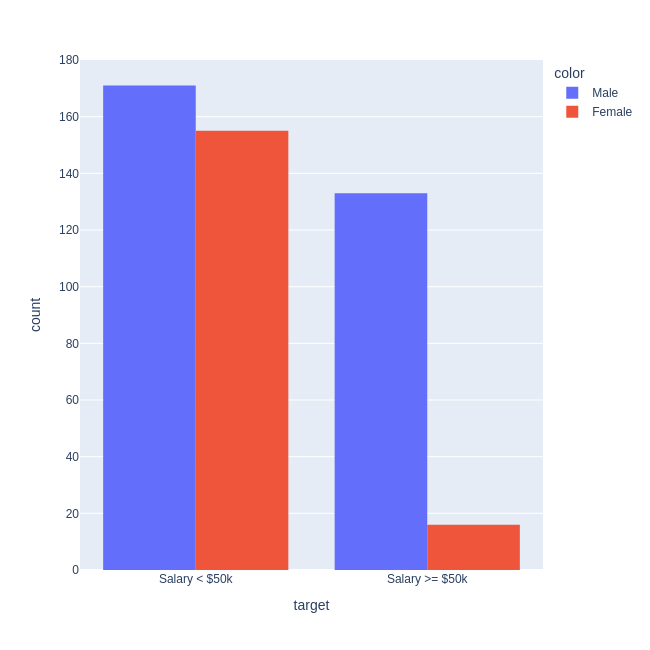

In [6]:
import plotly.express as px

fig = px.histogram(
    display_output_a,
    x="target",
    width=650,
    height=650,
    barmode="group",
    color=display_df.sex,
)
fig.show()

Then we also check the accuracy of the Trainee's predictions on the test set.

In [7]:
accuracy = round(accuracy_score(X_test["target"], predictions), 3)
accuracy

0.823

Since we are controlling for many of the features that are relevant to the Action Feature, this highlights the potential biases in the remaining features. We can see with the imbalance in representation across target values between sexes, a bias is evident. Men, despite being of the same work class and education level are much more likely than women to make over $50K in this dataset. 


### Step 2: Investigate Potential Relationship with Biased Feature - Sex and Relationship

Now that we identified `Sex` as a bias, we want to see the extent of the bias as it relates to other features. This is important because if we want to correct a biased feature, its relationships with other features can leave residual biases that persist if not addressed. You can think of the main biased feature as a weed whose roots can spread to other features.

#### Step 2a: Search for Other Affected Features

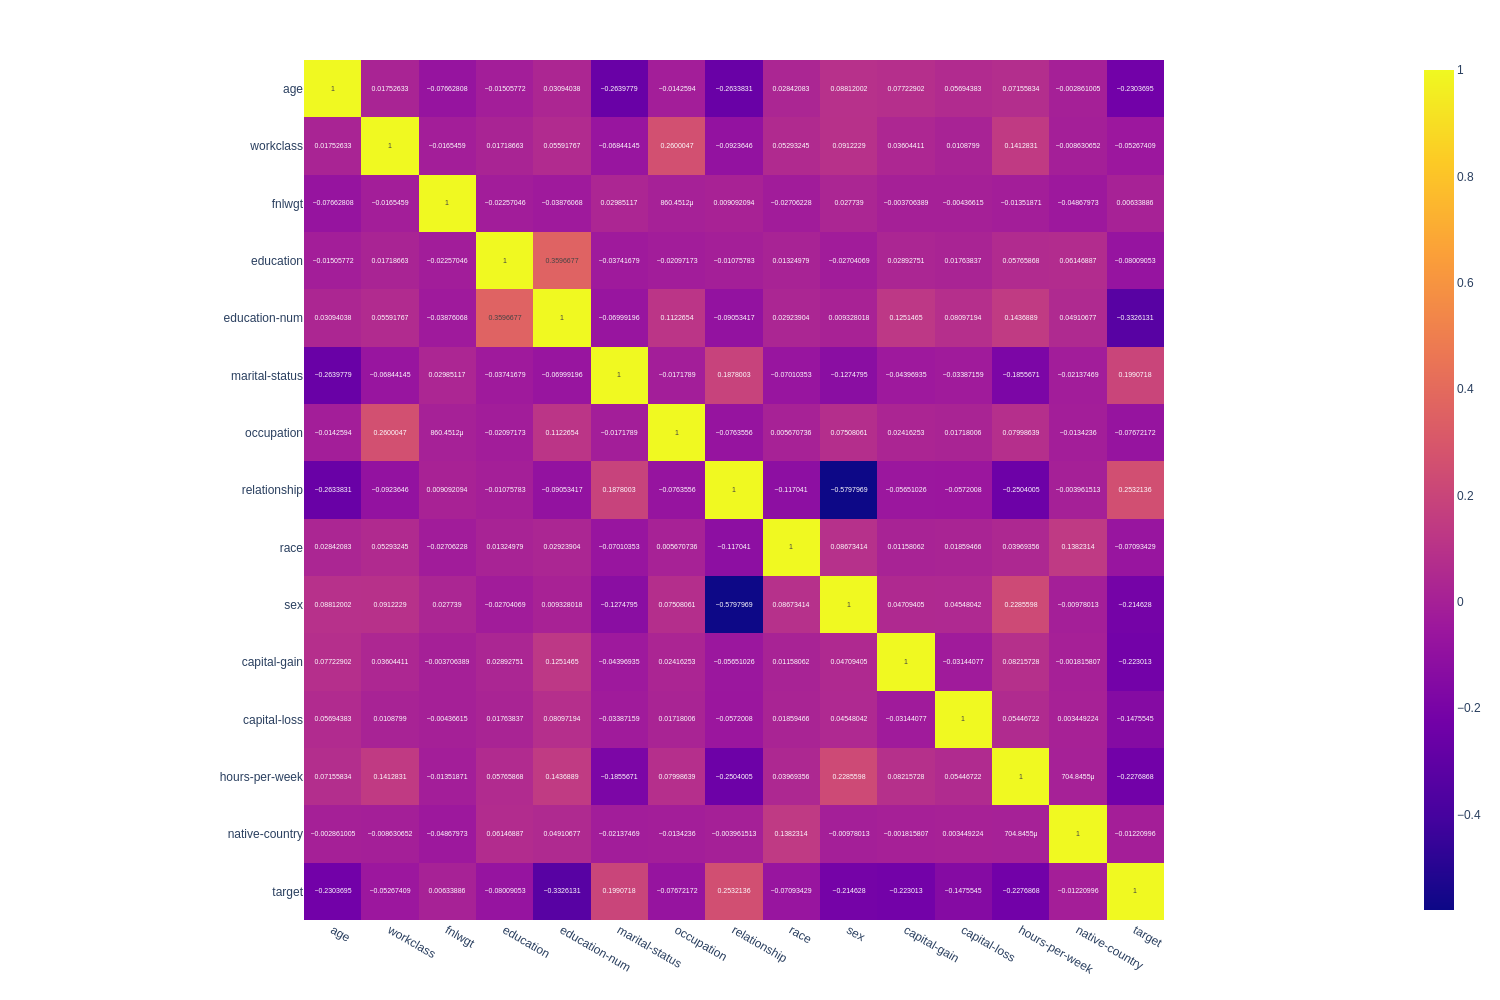

In [8]:
fig = px.imshow(df.corr(), text_auto=True, width=1500, height=1000)
fig.show()

We can see that `relationship` is correlated with `target`, while `sex` is strongly inversely correlated with both `target` and `relationship`. 
Another possible relationship of note is that between `age` and `target`, which are inversely correlated with one another. Whether these features should be considered sources of bias is up to the user, as features such as `sex` have a strong argument and other features, such as `age`, may represent a neutral relationship in the data as people making higher salaries as they age seems to be a reasonable relationship. Nonetheless, we will demonstrate controlling for age as an example.


### Step 3: Predict the Biased Feature

In [9]:
context_features = features.get_names(without=['sex'])
react = t.react(X_test, action_features=["sex"], context_features=context_features, details={"feature_mda_robust": True})

output = react["action"]
explanations = react["details"]

### Step 4: Verify

To further unravel some of the relationships between biased features using Howso Engine's explanations, we can verify the entanglement of `sex` and `relationship` by predicting `sex` and calculating the [mean decrease in accuracy](https://docs.howso.com/getting_started/terminology.html#mda) (MDA).

In [10]:
mdas = []
for explanation in explanations["feature_mda_robust"]:
    mdas.append(list(explanation.values()))

mdas = pd.DataFrame(mdas, columns=list(explanation.keys()))
display(mdas.mean(axis=0).sort_values(ascending=False).round(5))

relationship      0.02943
marital-status    0.01037
fnlwgt            0.00399
occupation        0.00332
age               0.00330
capital-gain      0.00313
target            0.00205
race              0.00083
education         0.00058
capital-loss      0.00048
hours-per-week   -0.00041
workclass        -0.00046
education-num    -0.00152
native-country   -0.00219
dtype: float64

We can see that `relationship` has a large MDA, confirming that `relationship` and `sex` have a strong relationship. 

Now that we have identified some features which may introduce bias, we can begin to mitigate them in two different ways using Howso Engine. We will measure the effectiveness of this mitigation visually and with a G-test p-value.

## Section 3: Control for Differences in `relationship`, `sex`, and `marital-status`.

### Step 1: Predict without Biased Features

In order to mitigate for these biased features, we will leave them out when using `react`. Note that since `marital-status` is correlated with `relationship`, we will also control for that. Since Howso Engine uses instance-based learning combined with sophisticated methods of handling NaNs, it can maintain high levels of performance even when features are left out.

In [11]:
context_features = features.get_names(without=['target', 'sex', 'relationship', 'marital-status'])
react = t.react(X_test, action_features=["target"], context_features=context_features)

output = react["action"]
predictions = output["target"]

### Step 2: Plot

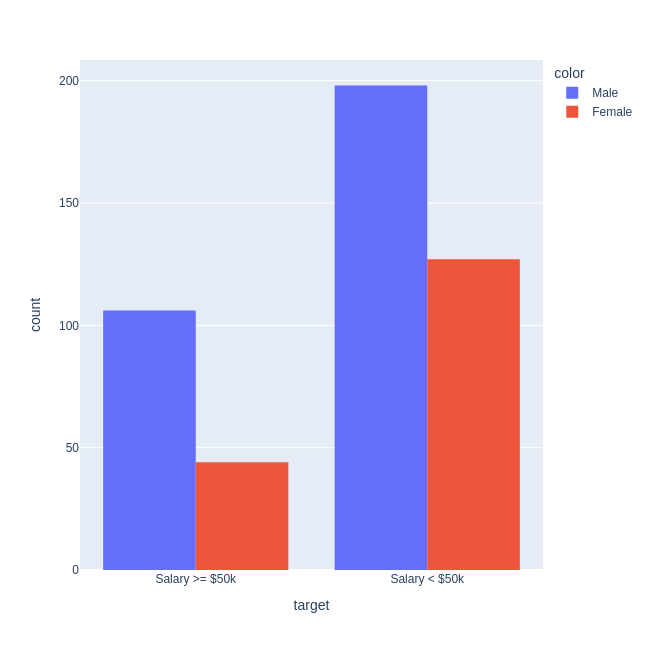

In [12]:
display_output_b = output.replace({"target": {0: "Salary >= $50k", 1: "Salary < $50k"}})
display_df = X_test.replace({
    "sex": {0: "Female", 1: "Male"},
    "target": {0: "Salary >= $50k", 1: "Salary < $50k"}
})

fig = px.histogram(
    display_output_b,
    x="target",
    width=650,
    height=650,
    barmode="group",
    color=display_df.sex,
)
fig.show()

### Step 3: Check Counts

We can see that the balance has been somewhat corrected, although this is not guaranteed. We can use a G-test to verify if this anecdote is backed up statistically by measuring the different counts. This may not be a complete fix, however it likely that the bias has improved.

In [13]:
counts = [
    [X_test.target.sum(), len(X_test) - X_test.target.sum()], [output.target.sum(), len(output) - output.target.sum()]
]

_, p, _, _ = chi2_contingency(counts, lambda_="log-likelihood")
print(f"p-value: {p}")

p-value: 0.4892843150001386


### Step 4: Check Accuracy

We can see that we still maintain relatively good accuracy compared to the original data set.

In [14]:
accuracy = round(accuracy_score(X_test["target"], predictions), 3)
accuracy

0.703

# Section 4: Control for Differences in Age

Unfortunately, it is possible that the balance not quite been addressed fully. Let's go back to that relationship between `age` and `target`, and see if we can't control for that. 

### Step 1: Assign Random Ages

We can do this by setting the age of each individual randomly in the range of 40 to 50. The Trainee will use these values to find the nearest trained Cases.

In [15]:
X_test_controlled = X_test

rng = np.random.default_rng()
X_test_controlled.age = rng.integers(40, 50, size=len(X_test_controlled))


### Step 2: React using Random Ages

In [16]:
output = t.react(X_test_controlled, action_features=["target"], context_features=context_features)["action"]
predictions = output["target"]

### Step 3: Graph

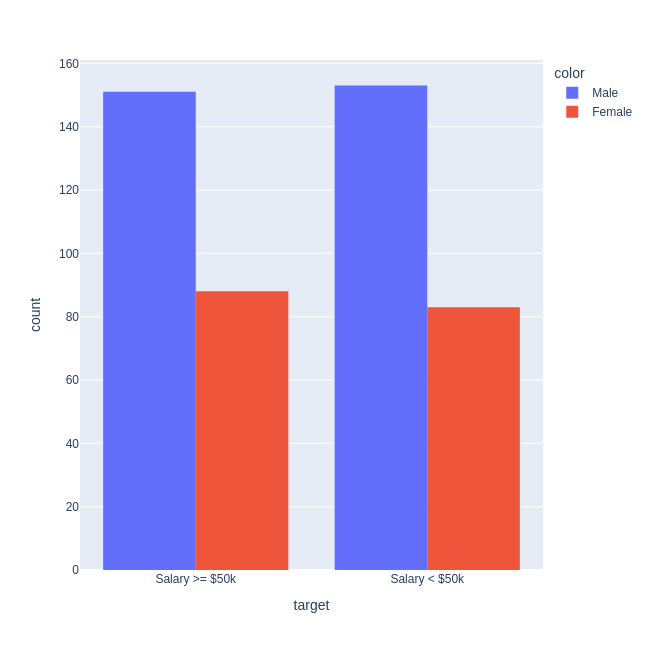

In [17]:
display_output_c = output.replace({"target": {0: "Salary >= $50k", 1: "Salary < $50k"}})
display_df = X_test.replace({
    "sex": {0: "Female", 1: "Male"},
    "target": {0: "Salary >= $50k", 1: "Salary < $50k"}
})

fig = px.histogram(
    display_output_c,
    x="target",
    width=650,
    height=650,
    barmode="group",
    color=display_df.sex,
)
fig.show()

### Step 4: Check Counts
Anecdotally, this distribution is much more equitable than either of the previous distributions. How does it fare statistically?

In [18]:
counts = [
    [X_test.target.sum(), len(X_test) - X_test.target.sum()], [output.target.sum(), len(output) - output.target.sum()]
]

_, p_value, _, _ = chi2_contingency(counts, lambda_="log-likelihood")
print(f"p-value: {p_value}")

p-value: 3.9248760728489275e-07


As we can see, the p-value is below even very low significance levels, indicating that there is a strong statistical difference between the original, inequitable distribution and the new distribution. We can compare the three distributions visually.

### Step 5: Check Accuracy

In [19]:
accuracy = round(accuracy_score(X_test["target"], predictions), 3)
accuracy

0.562

Unfortunately we can see that accuracy has dropped to a fairly low level. There is generally a trade off between accuracy and bias mitation, especially when testing is done in comparison to the original, biased data. The user must gauge this trade off carefully. At the same time, using only the accuracy score as the decision metric may paint an incomplete picture. For example, since the time in which our dataset, `Adult`, was created in 1996, there have been notable improvements in equality among sexes. Although not recommended, in a situation where we are using a dataset in 1996 to make inferences in present time, correcting for these biases may actually improve model performance on present test data as the bias is not as strong. These are all hypotheticals, but they illustrate the careful thought that must go into interpreting these results. 



# Section 5: Compare Bias Mitigation Techniques

This graph is shown just to give a side by side comparison of the changes controlling for the various features. 


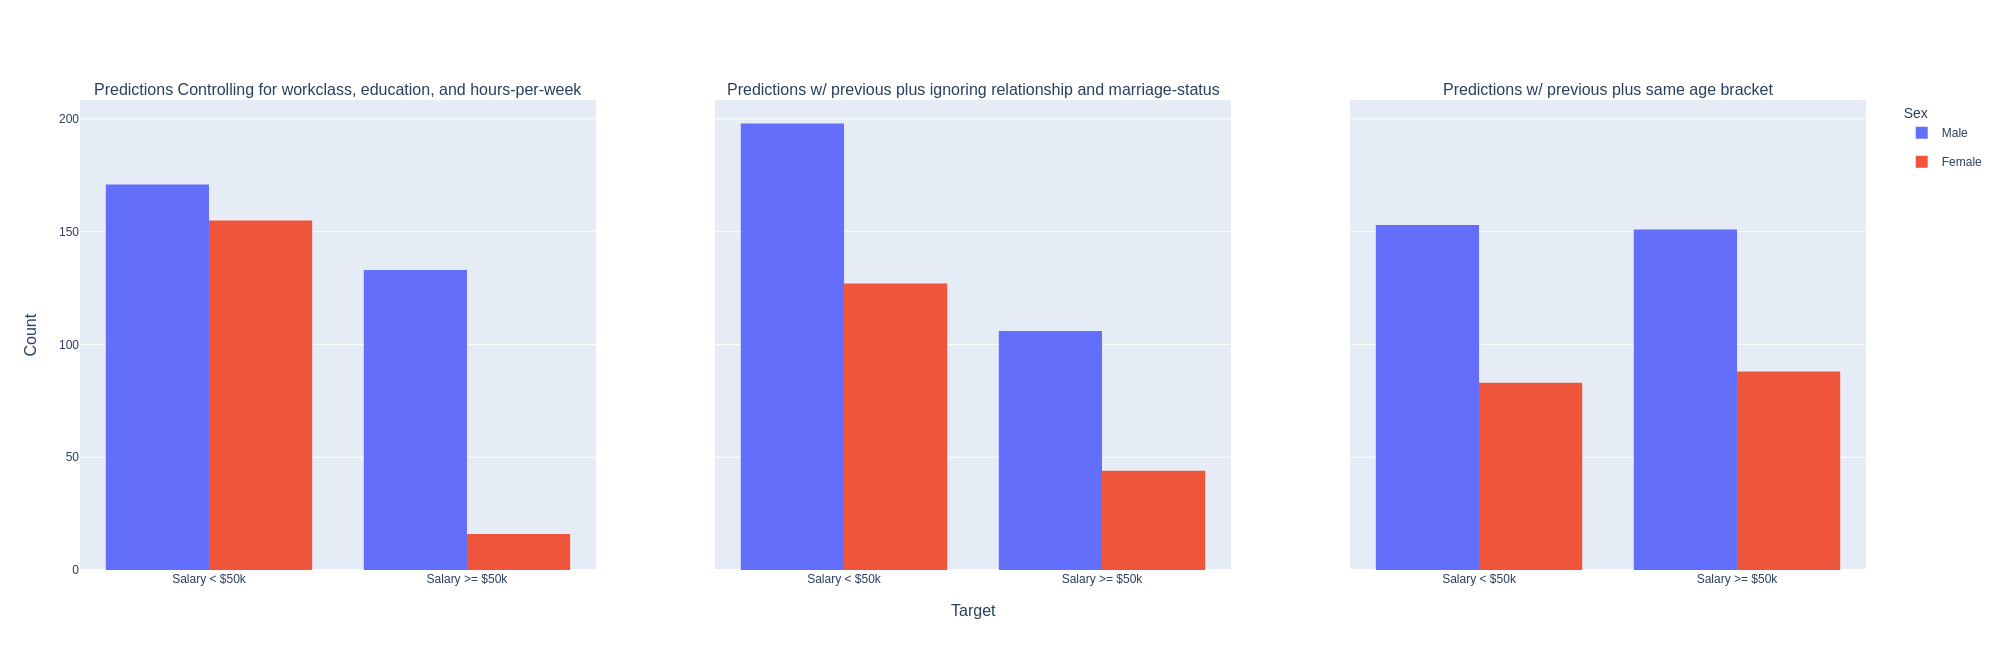

In [20]:
display_df = X_test.replace({
    "sex": {0: "Female", 1: "Male"},
    "target": {0: "Salary >= $50k", 1: "Salary < $50k"}
})

fa = px.histogram(
    display_output_a,
    x="target",
    barmode="group",
    color=display_df.sex,
    title="Predictions Controlling for\nworkclass, education, and hours-per-week",
)

fb = px.histogram(
    display_output_b,
    x="target",
    barmode="group",
    color=display_df.sex,
    title="Predictions w/ previous plus\nignoring relationship and marriage-status",
)

fc = px.histogram(
    display_output_c,
    x="target",
    barmode="group",
    color=display_df.sex,
    title="Predictions w/ previous plus\nsame age bracket",
)

fig = compose_figures([fa, fb, fc], 1, 3, shared_yaxes=True, x_title="Target", y_title="Count")
fig.update_layout(legend_title_text="Sex", width=2000, height=650)
fig.update_xaxes(categoryorder="array", categoryarray=["Salary < $50k", "Salary >= $50k"])
fig.show()


# Conclusion and next steps

As shown, Howso Engine enables effective data exploration and bias mitigation on a single model with one train and analysis. This should not be done without ample consideration, as data bias is not always a straightforward phenomenon. We see that if we control for certain features, we were likely to improve the quality of our Trainee without grealy impacting the performance, while for other features, the performance impact may be too strong. This means we must be selective in what we adjust for, and in our example, adjusting for `Age` is most likely not recommended due to the performance and lack of intuition on its bias. 

This recipe is meant to show a useful, unique, and thought-provoking use case. It is also meant to start opening up the door of possibilities of using Howso Engine. There are countless other use cases that the user may wish to explore and we leave that up to the user to continue. 